In [3]:
#!pip install keras
#!pip install tensorflow


# Import the libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import heapq

# Step 1: Create a synthetic dataset

In [5]:
np.random.seed(42)  # For reproducibility
num_samples = 1000

# Simulating some traffic data

In [6]:
data = {
    'timestamp': pd.date_range(start='2023-01-01', periods=num_samples, freq='H'),
    'traffic_volume': np.random.randint(100, 1000, size=num_samples),  # Random traffic volumes
    'temp': np.random.uniform(low=-10, high=30, size=num_samples),  # Temperature in Celsius
    'rain_1h': np.random.choice([0, 1], size=num_samples),  # 0 (no rain), 1 (rain)
    'snow_1h': np.random.choice([0, 1], size=num_samples)  # 0 (no snow), 1 (snow)
}


C:\Users\fofoh\AppData\Local\Temp\ipykernel_1700\2615139845.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range(start='2023-01-01', periods=num_samples, freq='H'),


In [7]:
df = pd.DataFrame(data)

### Print the first few rows of the raw data

In [8]:
print("Raw Data (First 5 Rows):")
print(df.head(), '\n')

Raw Data (First 5 Rows):
            timestamp  traffic_volume       temp  rain_1h  snow_1h
0 2023-01-01 00:00:00             202  15.465773        0        0
1 2023-01-01 01:00:00             535  12.192624        1        1
2 2023-01-01 02:00:00             960  -6.359916        0        1
3 2023-01-01 03:00:00             370  19.055881        1        0
4 2023-01-01 04:00:00             206  11.897852        0        0 



# Step 2: Feature selection (I'll use temp, rain, snow, and traffic_volume)

In [9]:
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

### Select relevant columns for prediction

In [10]:
features = df[['hour', 'day_of_week', 'temp', 'rain_1h', 'snow_1h']]
target = df['traffic_volume']

In [11]:
# Print the first few rows of the selected data
print("Selected Features and Target (First 5 Rows):")
print(features.head(), '\n')
print("Traffic Volume (First 5 Rows):")
print(target.head(), '\n')

Selected Features and Target (First 5 Rows):
   hour  day_of_week       temp  rain_1h  snow_1h
0     0            6  15.465773        0        0
1     1            6  12.192624        1        1
2     2            6  -6.359916        0        1
3     3            6  19.055881        1        0
4     4            6  11.897852        0        0 

Traffic Volume (First 5 Rows):
0    202
1    535
2    960
3    370
4    206
Name: traffic_volume, dtype: int32 



# Step 3: Preprocess the data

In [12]:
X = features.values  # Features
y = target.values  # Target


In [13]:
# Print X (features) and y (target) before scaling
print("X (Features) before Scaling (First 5 Rows):")
print(X[:5], '\n')

print("y (Traffic Volume) (First 5 Rows):")
print(y[:5], '\n')

X (Features) before Scaling (First 5 Rows):
[[ 0.          6.         15.46577286  0.          0.        ]
 [ 1.          6.         12.19262434  1.          1.        ]
 [ 2.          6.         -6.35991636  0.          1.        ]
 [ 3.          6.         19.05588131  1.          0.        ]
 [ 4.          6.         11.89785228  0.          0.        ]] 

y (Traffic Volume) (First 5 Rows):
[202 535 960 370 206] 



In [14]:
# Normalize features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

In [15]:
# Print X after scaling
print("X (Features) after Scaling (First 5 Rows):")
print(X_scaled[:5], '\n')

X (Features) after Scaling (First 5 Rows):
[[0.         1.         0.63696989 0.         0.        ]
 [0.04347826 1.         0.55506878 1.         1.        ]
 [0.08695652 1.         0.09084488 0.         1.        ]
 [0.13043478 1.         0.72680202 1.         0.        ]
 [0.17391304 1.         0.54769296 0.         0.        ]] 



In [16]:
# Reshape the data for LSTM: (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))


In [17]:
# Print the shape of X after reshaping for LSTM
print(f"Shape of X after Reshaping for LSTM: {X_scaled.shape}\n")

Shape of X after Reshaping for LSTM: (1000, 1, 5)



# Step 4: Train-test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [19]:
# Print shapes of training and test data
print(f"Training Data Shape (X_train): {X_train.shape}")
print(f"Test Data Shape (X_test): {X_test.shape}\n")

Training Data Shape (X_train): (800, 1, 5)
Test Data Shape (X_test): (200, 1, 5)



# Step 5: Build LSTM model

In [20]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

C:\Users\fofoh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.compile(optimizer='adam', loss='mse')


# Step 6: Train the model

In [22]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 361846.7188 - val_loss: 404523.5625
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 387602.5938 - val_loss: 403756.1875
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 374356.7812 - val_loss: 401322.3125
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 370682.8750 - val_loss: 396994.9688
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 362113.0938 - val_loss: 392942.1562
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 354590.3438 - val_loss: 389936.0000
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 359437.0312 - val_loss: 387634.3125
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 361648.2188 - val_loss: 385717.8750
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 368423.8438 - val_loss: 384031.4375
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 351069.4062 - val_loss: 382477.1562


# Step 7: Evaluate the model

In [23]:
loss = model.evaluate(X_test, y_test)
print(f'\nTest Loss: {loss}\n')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 384123.0000 

Test Loss: 382477.15625



# Step 8: Make predictions

In [24]:
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [25]:
# Print the first 5 predicted vs actual traffic volumes
print("Actual vs Predicted Traffic Volume (First 5 Predictions):")
for i in range(5):
    print(f"Actual: {y_test[i]}, Predicted: {y_pred[i][0]}")

Actual vs Predicted Traffic Volume (First 5 Predictions):
Actual: 363, Predicted: 20.175243377685547
Actual: 250, Predicted: 19.994739532470703
Actual: 138, Predicted: 19.8236141204834
Actual: 704, Predicted: 20.12447166442871
Actual: 708, Predicted: 19.924781799316406


# Step 8: Dijkstra's Algorithm

In [27]:
def dijkstra(graph, start):
    # Priority queue for tracking the shortest path
    queue = [(0, start)]  # (cost, node)
    distances = {node: float('infinity') for node in graph}
    distances[start] = 0
    while queue:
        current_distance, current_node = heapq.heappop(queue)

        # Nodes can only get added once with the shortest distance
        if current_distance > distances[current_node]:
            continue

        for neighbor, weight in graph[current_node].items():
            distance = current_distance + weight

            if distance < distances[neighbor]:
                distances[neighbor] = distance
                heapq.heappush(queue, (distance, neighbor))
    
    return distances


In [28]:
# Example graph represented as an adjacency list
graph = {
    'A': {'B': 1, 'C': 4},
    'B': {'A': 1, 'C': 2, 'D': 5},
    'C': {'A': 4, 'B': 2, 'D': 1},
    'D': {'B': 5, 'C': 1}
}


In [29]:
# Running Dijkstra's algorithm from starting node 'A'
shortest_paths = dijkstra(graph, 'A')
print("Shortest paths from node A:", shortest_paths)

Shortest paths from node A: {'A': 0, 'B': 1, 'C': 3, 'D': 4}


In [62]:
# Print the shortest paths from node A
print("\nShortest paths from node A:")
for node, distance in shortest_paths.items():
    print(f"Distance to {node}: {distance}")


Shortest paths from node A:
Distance to A: 0
Distance to B: 1
Distance to C: 3
Distance to D: 4


# Step 9: Plotting predictions vs actual traffic volume

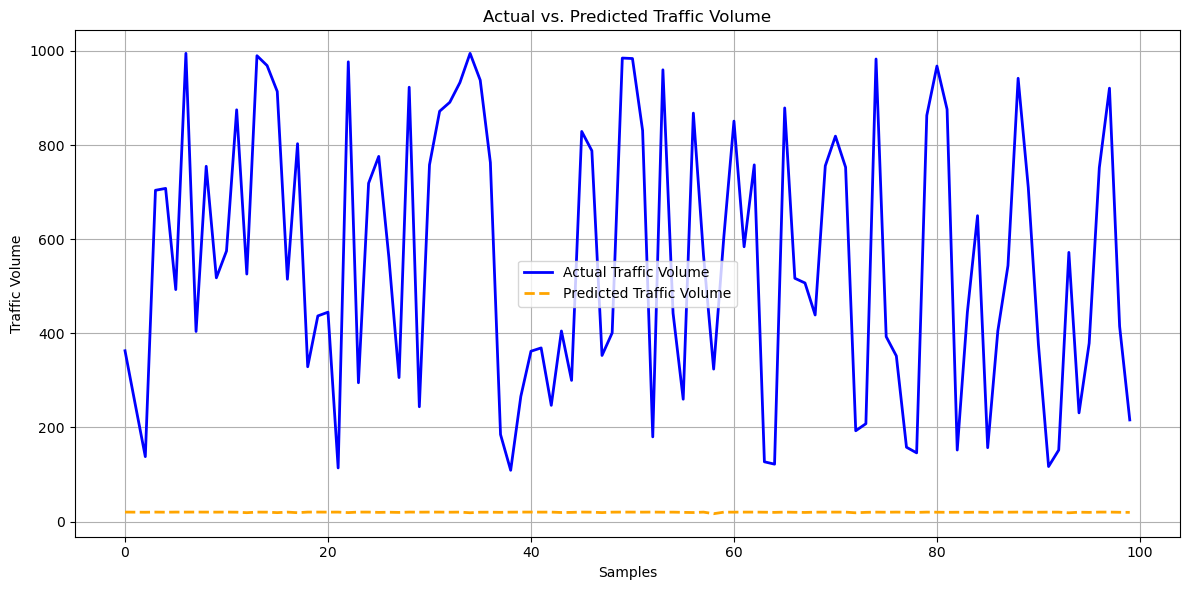

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual Traffic Volume', color='blue', linewidth=2)
plt.plot(y_pred[:100], label='Predicted Traffic Volume', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted Traffic Volume')
plt.xlabel('Samples')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Getting the shortest distances from the output of Dijkstra's algorithm

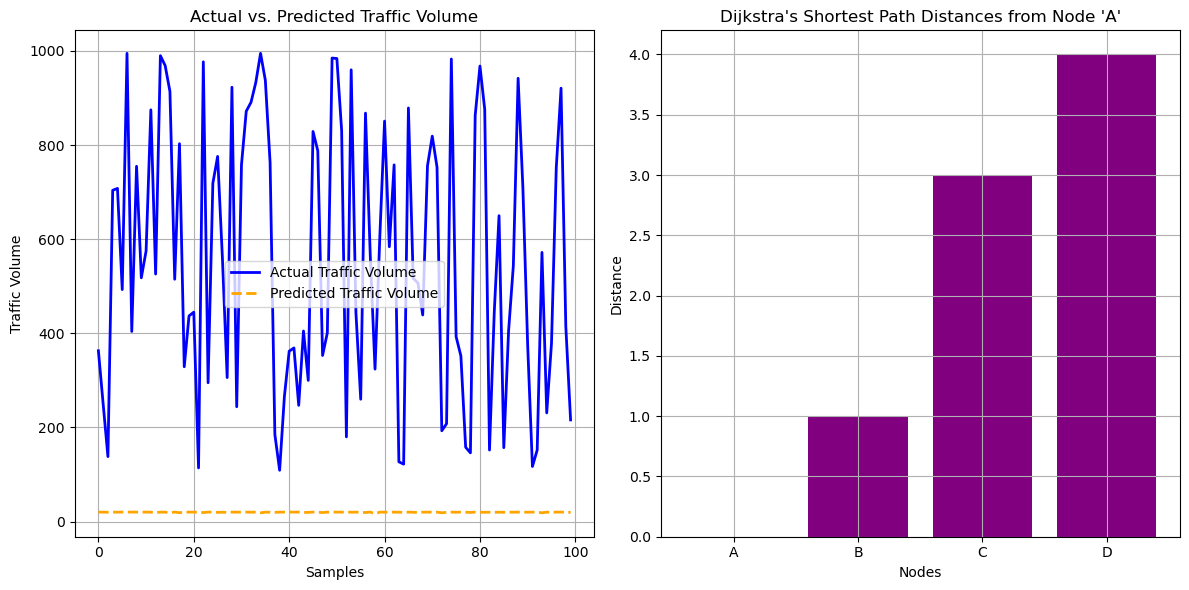

In [32]:
shortest_distances = list(shortest_paths.values())
nodes = list(shortest_paths.keys())

# Create a new figure for plotting
plt.figure(figsize=(12, 6))

# Plotting actual vs predicted traffic volume
plt.subplot(1, 2, 1)
plt.plot(y_test[:100], label='Actual Traffic Volume', color='blue', linewidth=2)
plt.plot(y_pred[:100], label='Predicted Traffic Volume', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted Traffic Volume')
plt.xlabel('Samples')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.legend()

# Plotting Dijkstra's shortest path distances
plt.subplot(1, 2, 2)
plt.bar(nodes, shortest_distances, color='purple')
plt.title("Dijkstra's Shortest Path Distances from Node 'A'")
plt.xlabel('Nodes')
plt.ylabel('Distance')
plt.grid(True)

plt.tight_layout()
plt.show()
